In [11]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from syd import make_viewer

from src.files import results_dir
from src.plotting import errorPlot
from src.iaf.source_population import SourcePopulationGabor
from src.iaf.analysis import (
    gather_metadata,
    gather_results,
    gather_rates,
    gather_weights,
    get_groupnames,
    sort_orientation_preference,
    summarize_weights,
)
from src.iaf.plotting import weights_to_gabor

In [4]:
experiment_folder = results_dir("iaf_runs") / "hofer" / "20250320"
metadata = gather_metadata(experiment_folder, experiment_type="hofer")
firing_rates = gather_rates(metadata, experiment_type="hofer")
weights = gather_weights(metadata, experiment_type="hofer", average_method="fraction", average_window=0.2, normalize=True)

In [5]:
results = gather_results(metadata)

In [10]:
orientation_preference = {sg: np.argmax(weights[sg], axis=-1) % 4 for sg in get_groupnames()}
weights_preferred = sort_orientation_preference(weights, orientation_preference["proximal"])

In [11]:
summary = summarize_weights(weights, orientation_preference["proximal"])

In [12]:
location_order = ["central", "edge", "outer"]
orientation_order = ["preferred", "other"]
weight_group_order = [f"{loc}-{ori}" for ori in orientation_order for loc in location_order]

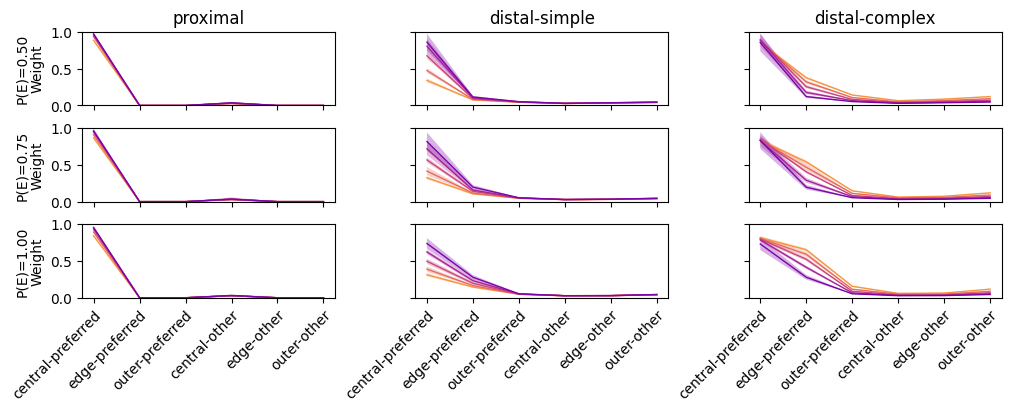

In [13]:
num_edges = len(metadata["edge_probabilities"])
num_ratios = len(metadata["dp_ratios"])
cmap = mpl.colormaps["plasma_r"]
colors = [cmap(ii) for ii in np.linspace(0, 1, num_ratios+4)[2:-2]]

fig, ax = plt.subplots(num_edges, 3, layout="constrained", figsize=(10, 4), sharex=True, sharey=True)
for iedge in range(num_edges):
    for igroup, sgname in enumerate(get_groupnames()):
        for iratio in range(num_ratios):
            data = np.stack([np.reshape(summary[wg][igroup, iratio, iedge], -1) for wg in weight_group_order])
            errorPlot(range(6), data, axis=1, ax=ax[iedge, igroup], color=colors[iratio], linewidth=1.0, alpha=0.3)
        ax[iedge, igroup].set_ylim(0, 1)

for igroup, sgname in enumerate(get_groupnames()):
    ax[0, igroup].set_title(sgname)
    ax[-1, igroup].set_xticks(range(len(weight_group_order)), labels=weight_group_order, rotation=45, ha="right", rotation_mode="anchor")
for iedge in range(num_edges):
    ax[iedge, 0].set_ylabel(f"P(E)={metadata['edge_probabilities'][iedge]:.2f}\nWeight")

plt.show()

In [14]:
def plot(state):
    dpratio = state["dpratio"]
    edge = state["edge"]
    simulation = state["simulation"]
    neuron = state["neuron"]
    spacing = state["spacing"]
    vmax = state["vmax"]

    proximal_gabor = weights_to_gabor(weights["proximal"][dpratio, edge, simulation, neuron], SourcePopulationGabor.orientations, spacing=spacing)
    simple_gabor = weights_to_gabor(weights["distal-simple"][dpratio, edge, simulation, neuron], SourcePopulationGabor.orientations, spacing=spacing)
    complex_gabor = weights_to_gabor(weights["distal-complex"][dpratio, edge, simulation, neuron], SourcePopulationGabor.orientations, spacing=spacing)

    fig, ax = plt.subplots(1, 3, figsize=(9, 3), layout="constrained")
    ax[0].imshow(proximal_gabor, vmin=-vmax, vmax=vmax, cmap="bwr")
    ax[0].set_title(f"{np.max(proximal_gabor)}")
    ax[1].imshow(simple_gabor, vmin=-vmax, vmax=vmax, cmap="bwr")
    ax[1].set_title(f"{np.max(simple_gabor)}")
    ax[2].imshow(complex_gabor, vmin=-vmax, vmax=vmax, cmap="bwr")
    ax[2].set_title(f"{np.max(complex_gabor)}")
    return fig

viewer = make_viewer(plot)
viewer.add_integer("dpratio", min=0, max=4)
viewer.add_integer("edge", min=0, max=2)
viewer.add_integer("simulation", min=0, max=9)
viewer.add_integer("neuron", min=0, max=2)
viewer.add_integer("spacing", value=2, min=0, max=10)
viewer.add_float("vmax", value=0.5, min=0.0, max=1.0)
viewer.show()